In [394]:
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import signal
import random

from steerable_pyramid import SteerablePyramid
from phase_utils import *
from pyramid_utils import build_level, build_level_batch, recon_level_batch
from optical_flow import *

%matplotlib inline

### Obtain Video

In [395]:
video_path = "source_videos/highway_2.mp4"

In [396]:
def get_frames(video_path, num_frames=3, start_idx=0, isRandom=False):
    cap = cv2.VideoCapture(video_path)
    
    fs = cap.get(cv2.CAP_PROP_FPS)
    
    if not cap.isOpened():
        raise ValueError("Unable to open the video file.")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < 1:
        raise ValueError("The video contains no frames.")
    if num_frames > total_frames:
        raise ValueError(f"Requested number of frames ({num_frames}) exceeds total frames ({total_frames}).")
    
    frame_indices = []
    if isRandom:
        frame_indices = random.sample(range(total_frames), num_frames)
    else:
        if start_idx + num_frames > total_frames:
            raise ValueError(f"Start index and number of frames exceed total frames ({total_frames}).")
        frame_indices = list(range(start_idx, start_idx + num_frames))
    
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)  # Move to the desired frame
        ret, frame = cap.read()
        if not ret:
            raise ValueError(f"Could not read frame at index {idx}.")
        frames.append(frame)

    cap.release()
    return frames, fs

In [397]:
# original frames
bgr_frames, fs = get_frames(video_path, num_frames=3, start_idx=30, isRandom=False)

In [398]:
frames = [] # frames for processing

for frame in bgr_frames:
    # get normalized YIQ frame
    rgb = np.float32(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)/255)
    yiq = rgb2yiq(rgb)

    # append resized Luma channel 
    frames.append(yiq[:, :, 0])

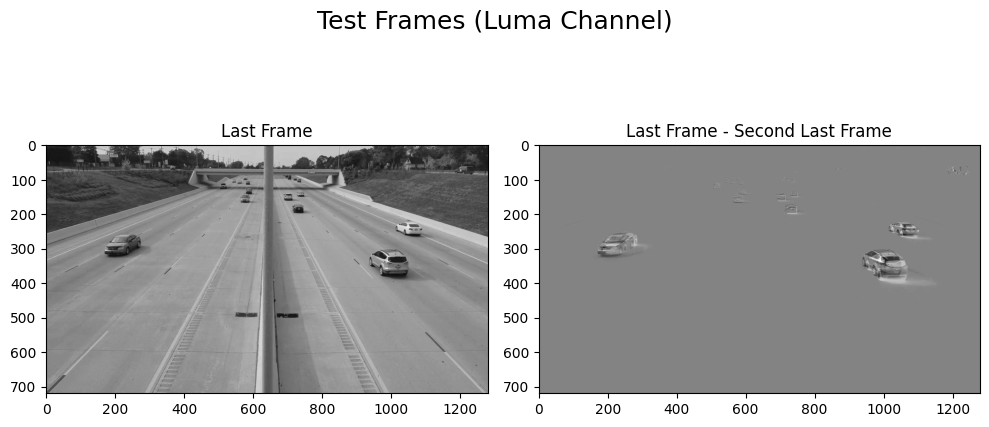

In [399]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Test Frames (Luma Channel)", size=18)
ax[0].imshow(frames[-1], cmap='gray')
ax[0].set_title("Last Frame")
ax[1].imshow(np.float32(frames[-1]) - np.float32(frames[-2]), cmap='gray')
ax[1].set_title("Last Frame - Second Last Frame")

plt.tight_layout()
plt.show()

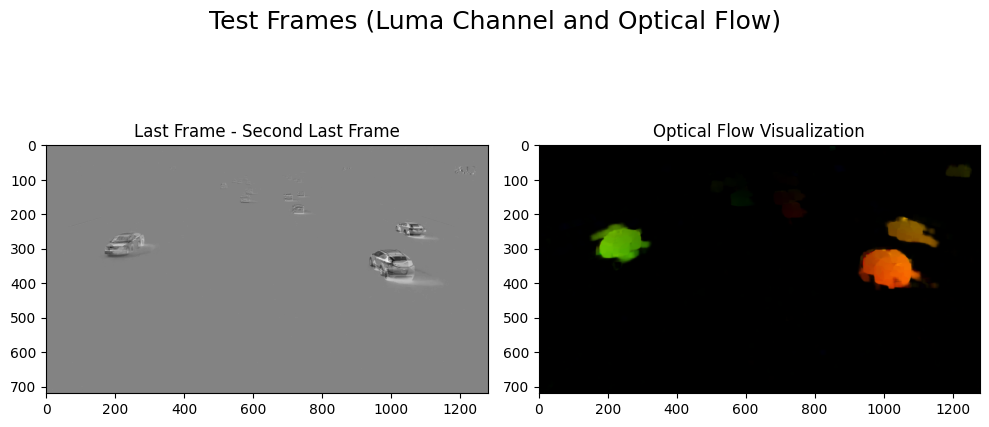

In [400]:
dense_optical_flow_frame = dense_optical_flow(bgr_frames)

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Test Frames (Luma Channel and Optical Flow)", size=18)

# Son frame (Luma kanalında)
ax[0].imshow(np.float32(frames[-1]) - np.float32(frames[-2]), cmap='gray')
ax[0].set_title("Last Frame - Second Last Frame")

# Optical flow görselleştirme
ax[1].imshow(dense_optical_flow_frame[-1], cmap=None)  # Optical flow zaten RGB renkli bir çıktı
ax[1].set_title("Optical Flow Visualization")

plt.tight_layout()
plt.show()


## **0. Set Hyperparameters**

In [401]:
# use first frame as the reference frame
ref_idx = 0
ref_frame = frames[ref_idx]
h, w = ref_frame.shape

# video length
num_frames = len(frames) # TODO sil

# factor to avoid division by 0
eps = 1e-6

# CUDA Parallelization
batch_size = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [402]:
# Bandpass Filter Frequencies
f_lo = 0.2 
f_hi = 0.25 

# weighted amplitude blur parameters
sigma = 5.0 

# attenuate other frequencies
attenuate = True

# phase magnification factor
phase_mag = 0.5

#### Get Gaussian Kernel for Amplitude weighted Blurring

In [403]:
# ensure ksize is odd or the filtering will take too long
# see warning in: https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html
ksize = np.max((3, np.ceil(4*sigma) - 1)).astype(int)
if ((ksize % 2) != 1):
    ksize += 1

# get Gaussian Blur Kernel for reference only
gk = cv2.getGaussianKernel(ksize=ksize, sigma=sigma)
gauss_kernel = torch.tensor(gk @ gk.T).type(torch.float32) \
                                      .to(device) \
                                      .unsqueeze(0) \
                                      .unsqueeze(0)

In [404]:
# check that the Gaussian Kernel dimensions are odd
gauss_kernel.shape

torch.Size([1, 1, 19, 19])

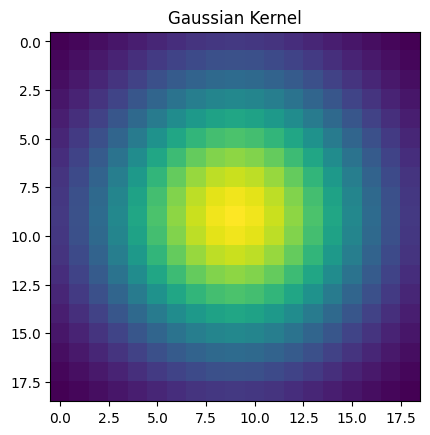

In [405]:
plt.imshow(gk @ gk.T);
plt.title("Gaussian Kernel");

In [406]:
# normalize freqeuncies to the Nyquist rate range of [0, 1]
norm_f_lo = f_lo / fs * 2
norm_f_hi = f_hi / fs * 2

# Get Bandpass Impulse Response
bandpass = signal.firwin(numtaps=len(frames), 
                         cutoff=[norm_f_lo, norm_f_hi], 
                         pass_zero=False)

# we also pass unnormalized freqeuncies as long as we include the sample rate fs
# bandpass = signal.firwin(numtaps=len(frames), 
#                          cutoff=[f_lo, f_hi], 
#                          pass_zero=False,
#                          fs=fs)

# Get Frequency Domain Transfer Function
transfer_function = torch.fft.fft(
    torch.fft.ifftshift(torch.tensor(bandpass))).to(device) \
                                                .type(torch.complex64)
transfer_function = torch.tile(transfer_function, 
                               [1, 1, 1, 1]).permute(0, 3, 1, 2)

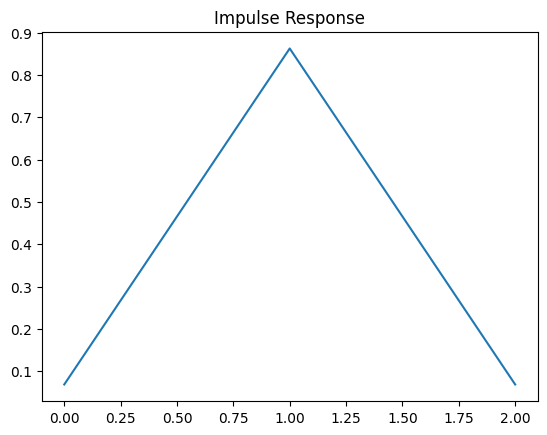

In [407]:
plt.plot(bandpass)
plt.title("Impulse Response");

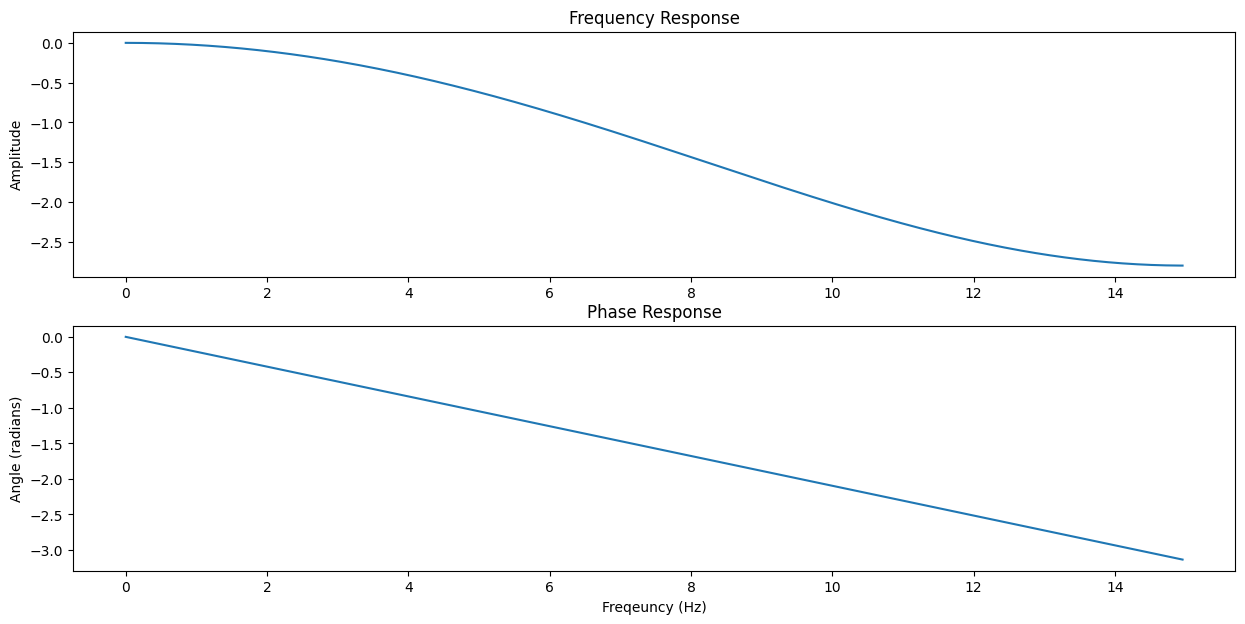

In [408]:
norm_freqs, response = signal.freqz(bandpass)
freqs = norm_freqs / np.pi * fs/ 2 

_, ax = plt.subplots(2, 1, figsize=(15, 7))
ax[0].plot(freqs, 20*np.log10(np.abs(response)));
ax[0].set_title("Frequency Response");
ax[0].set_ylabel("Amplitude");

ax[1].plot(freqs, np.angle(response));
ax[1].set_title("Phase Response");
ax[1].set_xlabel("Freqeuncy (Hz)");
ax[1].set_ylabel("Angle (radians)");

## **1. Get CSP Filters**

Try out different Steerable Pyramid options

In [409]:
max_depth = int(np.floor(np.log2(np.min(np.array(ref_frame.shape)))) - 2)

# Regular Pyramids with SubOctave Filter Scaling
# csp = SteerablePyramid(depth=max_depth, orientations=4, filters_per_octave=1, twidth=1.0, complex_pyr=True)
csp = SteerablePyramid(depth=max_depth, orientations=8, filters_per_octave=2, twidth=0.75, complex_pyr=True)
# csp = SteerablePyramid(depth=max_depth, orientations=8, filters_per_octave=2, twidth=0.25, complex_pyr=True)

# SubOctave Pyramids
# csp = SuboctaveSP(depth=max_depth-1, orientations=8, filters_per_octave=2, cos_order=6, complex_pyr=True) 
# csp = SuboctaveSP(depth=max_depth, orientations=8, filters_per_octave=4, cos_order=6, complex_pyr=True) 

filters, crops = csp.get_filters(h, w, cropped=False)

print(f"Number of Pyramid Filters: {len(filters)}")

Number of Pyramid Filters: 114


## Display Freqeuncy Partition of Oriented Sub-Band Filters

In [410]:
filter_partition = np.dstack(filters[1:-1]).sum(axis=-1)

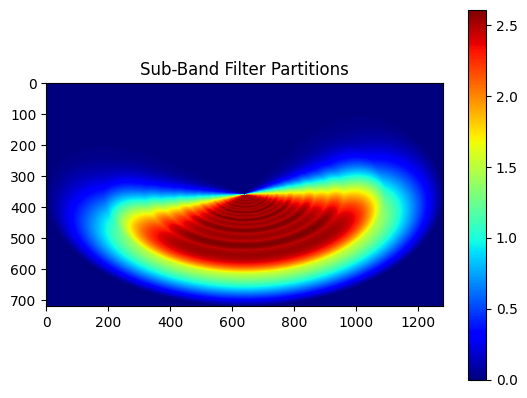

In [411]:
plt.imshow(filter_partition, cmap='jet');
plt.title("Sub-Band Filter Partitions");
plt.colorbar();

In [412]:
color_filter_partition = np.zeros_like(filter_partition[:, :, None].repeat(3, axis=2))

for i in range(1, len(filters[1:-1])):
    # scramble the colors!
    tmp_filt = filters[i][:, :, None].repeat(3, axis=2) * np.array(cmap(i)[:3])

    # scramble the colors!
    # blue = int(i*30 % 256)/255
    # green = int(i*103 % 256)/255
    # red = int(i*50 % 256)/255

    # tmp_filt = filters[i][:, :, None].repeat(3, axis=2) * 2*np.array([red, blue, green])
    
    color_filter_partition += tmp_filt/3

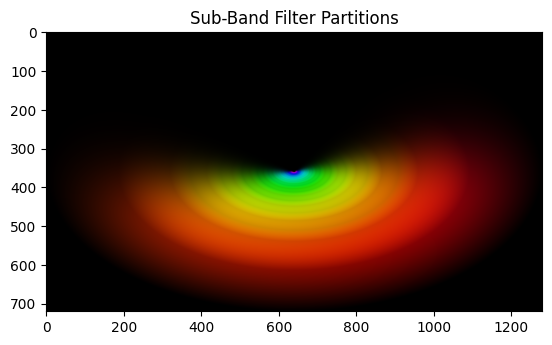

In [413]:
plt.imshow(color_filter_partition)
plt.title("Sub-Band Filter Partitions");

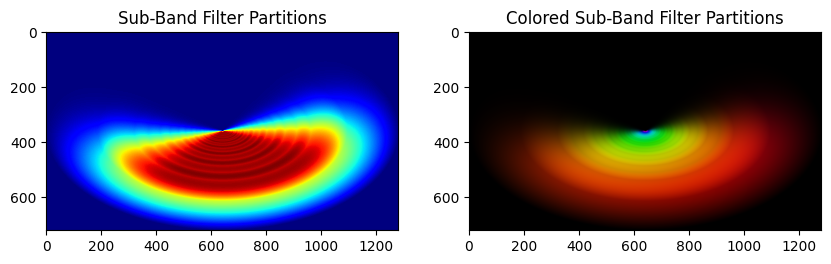

In [414]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(filter_partition, cmap='jet')
ax[0].set_title("Sub-Band Filter Partitions")

ax[1].imshow(color_filter_partition)
ax[1].set_title("Colored Sub-Band Filter Partitions");

Get Filters Tensor

In [415]:
filters_tensor = torch.tensor(np.array(filters)).type(torch.float32).to(device)

## **2. Compute DFT for each frame of the video**

In [416]:
## Get DFT of all video frames
frames_tensor = torch.tensor(np.array(frames)).type(torch.float32).to(device)
video_dft = torch.fft.fftshift(torch.fft.fft2(frames_tensor, dim=(1,2))).type(torch.complex64).to(device)

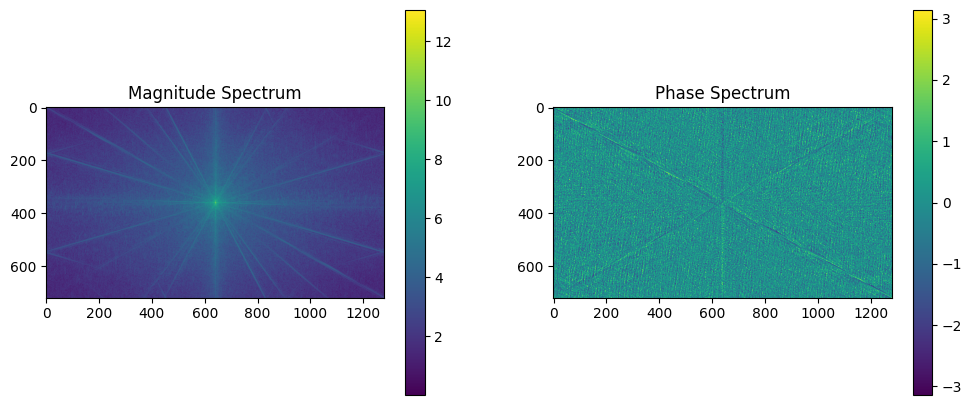

In [417]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Extract the first frame's DFT result from the video DFT tensor
first_frame_dft = video_dft[0]

# Calculate magnitude and phase of the DFT
magnitude = torch.abs(first_frame_dft)
phase = torch.angle(first_frame_dft)

# Convert to numpy for visualization
magnitude_np = magnitude.cpu().numpy()
phase_np = phase.cpu().numpy()

# Plot magnitude and phase
plt.figure(figsize=(12, 5))

# Display magnitude
plt.subplot(1, 2, 1)
plt.imshow(np.log1p(magnitude_np))  # Log scale for better visualization
plt.title('Magnitude Spectrum')
plt.colorbar()

# Display phase
plt.subplot(1, 2, 2)
plt.imshow(phase_np)
plt.title('Phase Spectrum')
plt.colorbar()

plt.show()

Create Tensor to store DFT of of motion magnified frames

In [418]:
recon_dft = torch.zeros((len(frames), h, w), dtype=torch.complex64).to(device)

#### Setup filter2D for PyTorch with circular padding

The Torch Functional implementation of conv2d does not have the option for circular padding! But it seems like this approach takes longer, more than twice as long! :(

In [419]:
import torch.nn as nn

filter2D = nn.Conv2d(in_channels=1, out_channels=1,
                     kernel_size=gauss_kernel.shape[2:], 
                     padding='same',
                     padding_mode='circular',
                     groups=1, 
                     bias=False)

filter2D.weight.data = gauss_kernel
filter2D.weight.requires_grad = False

## **3. For each Pyramid Level**

In [420]:
phase_deltas = torch.zeros((batch_size, len(frames), h, w), dtype=torch.complex64).to(device)

for level in range(1, len(filters) - 1, batch_size):

    # get batch indices
    idx1 = level
    idx2 = level + batch_size

    # get current filter batch
    filter_batch = filters_tensor[idx1:idx2]

    ## get reference frame pyramid and phase (DC)
    ref_pyr = build_level_batch(video_dft[ref_idx, :, :].unsqueeze(0), filter_batch)
    ref_phase = torch.angle(ref_pyr)

    ## Get Phase Deltas for each frame
    for vid_idx in range(num_frames):

        curr_pyr = build_level_batch(
                        video_dft[vid_idx, :, :].unsqueeze(0), filter_batch)

        # unwrapped phase delta
        _delta = ref_phase - torch.angle(curr_pyr)

        # get phase delta wrapped to [-pi, pi]
        phase_deltas[:, vid_idx, :, :] = ((torch.pi + _delta) \
                                            % 2*torch.pi) - torch.pi
    
    ## Temporally Filter the phase deltas
    # Filter in Frequency Domain and convert back to phase space
    phase_deltas = torch.fft.ifft(transfer_function \
                                  * torch.fft.fft(phase_deltas, dim=1),  
                                  dim=1).real

    ## Apply Motion Magnifications
    for vid_idx in range(num_frames):

        curr_pyr = build_level_batch(video_dft[vid_idx, :, :].unsqueeze(0), filter_batch)
        delta = phase_deltas[:, vid_idx, :, :]

        ## Perform Amplitude Weighted Blurring
        if sigma != 0:
            amplitude_weight = torch.abs(curr_pyr) + eps
            
            # Torch Functional Approach (faster)
            weight = F.conv2d(input=amplitude_weight.unsqueeze(1), 
                              weight=gauss_kernel, 
                              padding='same').squeeze(1)
            
            delta = F.conv2d(input=(amplitude_weight * delta).unsqueeze(1), 
                              weight=gauss_kernel, 
                              padding='same').squeeze(1) 

            # Torch nn approach with circular padding (SLOWER)
            # weight = filter2D(amplitude_weight.unsqueeze(1)).squeeze(1)
            # delta = filter2D((amplitude_weight * delta).unsqueeze(1)).squeeze(1)
            
            # get weighted Phase Deltas
            delta /= weight

        ## Modify phase variation
    
        #modifed_phase = delta * phase_mag
        modifed_phase = - delta * phase_mag #! in original implementation delta not delta

        ## Attenuate other frequencies by scaling magnitude by reference phase
        if attenuate:
            curr_pyr = torch.abs(curr_pyr) * (ref_pyr/torch.abs(ref_pyr)) 

        ## apply modified phase to current level pyramid decomposition
        # if modified_phase = 0, then no change!
        curr_pyr = curr_pyr * torch.exp(1.0j*modifed_phase) # ensures correct type casting

        ## accumulate reconstruced levels
        recon_dft[vid_idx, :, :] += recon_level_batch(curr_pyr, filter_batch).sum(dim=0)

Note on attenuating unwanted frequencies

In the vanilla implemntation, we add the motion magnified phase delta to the complex filter decomposition. This takes the current phase and adds in the additional motion amplification. When we attenate other frequencies, we are adding the delta phase to the magnitude of the filter decomposition. Taking the magnitude of the filter decomposition removes all phase components, inserting the phase delta provides motion information for only the frequency bands that we are interested in (as filtered by the temporal bandpass filter)

## **4. Add Hi and Lo Components to the reconstructed DFT**

In [421]:
# adding hipass component seems to cause bad artifacts and leaving
# it out doesn't seem to impact the overall quality
hipass = filters_tensor[0]
lopass = filters_tensor[-1]

## add back lo and hi pass components
for vid_idx in range(num_frames):
    # accumulate Lo Pass Components
    curr_pyr_lo = build_level(video_dft[vid_idx, :, :], lopass)
    dft_lo = torch.fft.fftshift(torch.fft.fft2(curr_pyr_lo))
    recon_dft[vid_idx, :, :] += dft_lo*lopass

    # # OPTIONAL accumulate Lo Pass Components
    # curr_pyr_hi = build_level(video_dft[vid_idx, :, :], hipass)
    # dft_hi = torch.fft.fftshift(torch.fft.fft2(curr_pyr_hi)) 
    # recon_dft[vid_idx, :, :] += dft_hi*hipass

Check DFT Magnitude

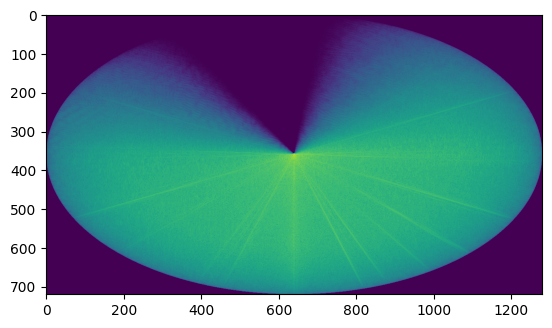

In [422]:
plt.imshow(np.log(np.abs(recon_dft[1, :, :].cpu()) + 1e-6));

## **5. Get Inverse DFT of entire results DFT**

In [423]:
result_video = torch.fft.ifft2(torch.fft.ifftshift(recon_dft, dim=(1,2)), dim=(1,2)).real

In [424]:
# remove from CUDA
result_video = result_video.cpu()

Observe reconstruction error

In [425]:
print(torch.sum(torch.abs(frames_tensor[0, :, :].cpu() - result_video[0, :, :])),
      torch.mean(torch.square(frames_tensor[0, :, :].cpu() - result_video[0, :, :]).float()))

tensor(19681.3750) tensor(0.0028)


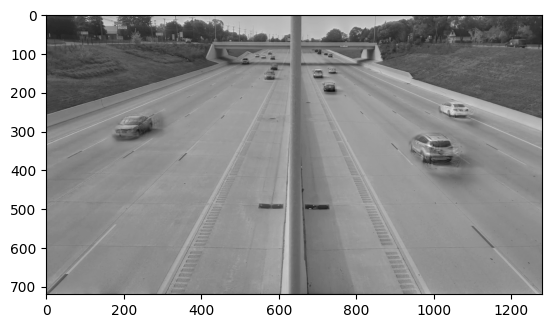

In [426]:
plt.imshow(result_video[-1, :, :], cmap='gray');

In [427]:
rgb_modified = []

for vid_idx in range(num_frames):
    # get current OG YIQ frame and resized result Luma Frame
    rgb = np.float32(cv2.cvtColor(bgr_frames[vid_idx], cv2.COLOR_BGR2RGB)/255)
    yiq_frame = rgb2yiq(rgb)

    result_frame = cv2.resize(result_video[vid_idx, :, :].numpy(), (w, h))

    # modify YIQ frame with motion magnified Luma channel
    yiq_frame[:, :, 0] = result_frame

    # convert to rgb
    rgb_frame = yiq2rgb(yiq_frame)

    # normalize
    rgb_frame = cv2.convertScaleAbs(rgb_frame, alpha=255, beta=0)

    rgb_modified.append(rgb_frame)

## **Make Video of Results**

In [428]:
stacked_frames = []
middle = np.zeros((h, 3, 3)).astype(np.uint8)
stacked_frame = np.hstack((bgr_frames[-1], 
                       middle, 
                       cv2.cvtColor(rgb_modified[-1], cv2.COLOR_RGB2BGR)))


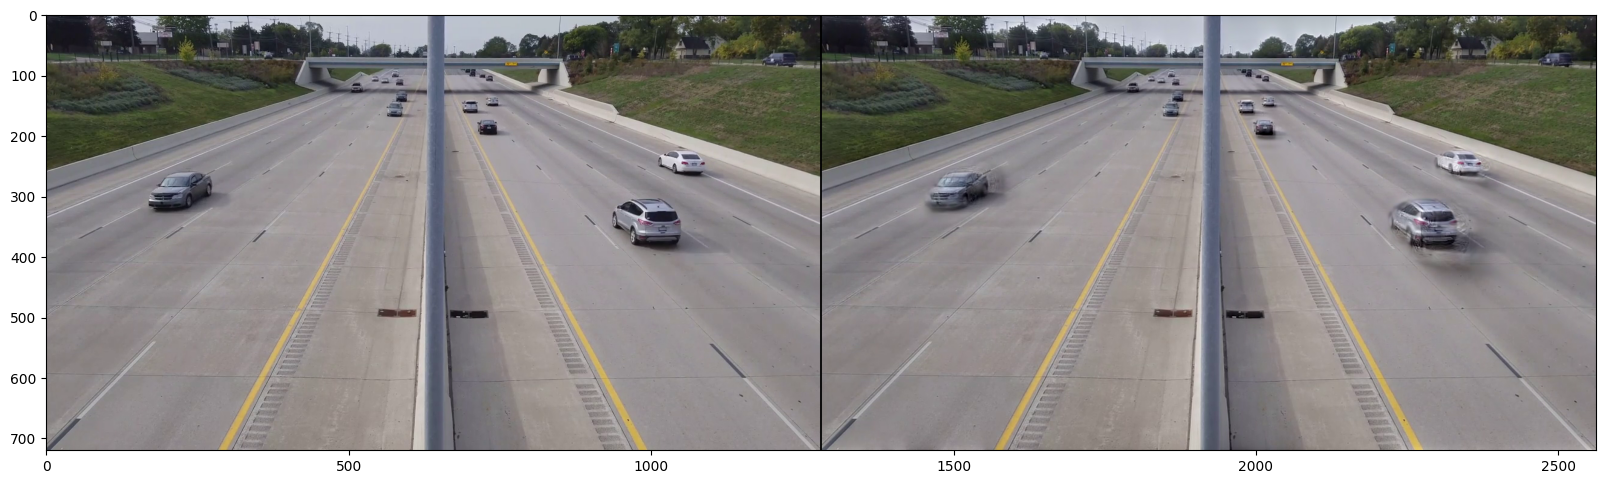

In [429]:
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(stacked_frame, cv2.COLOR_BGR2RGB));